# **UNIVERSIDAD INTERNACIONAL DEL ECUADOR**
##  *Maestría en Ciencia de Datos y Máquinas de Aprendizaje Mención Inteligencia Artificial*
### Materia: Neural Networks: Deep Learning


---


## **TRABAJO PRÁTICO**


---

### **Grupo 6**

### Integrantes:

*   Bonilla Zárate, Maria Camila
*   Saguay Saguay, Bryan Alexanders
*   Carranza Villaroel, Carlos Daniel  
*   Lincango Simbaña, Betsy Belén

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)

TensorFlow: 2.16.2
NumPy: 1.26.4


In [27]:
import os, glob, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from tensorflow.keras.models import load_model
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    f1_score, 
    accuracy_score,
    mean_squared_error,
    roc_curve, 
    auc,
    precision_recall_curve,
    average_precision_score
)



In [3]:
import os
data_dir = os.path.join(os.getcwd(), "dataset")
print(data_dir)

/Users/betsybelen/Documents/UIDE/Tesis/retinopatia-diabetica-UI/dataset


In [4]:
# Configuración de estilo para gráficas
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [36]:
# Rutas 
MODEL_PATH = './transfer_learning/model/vgg16_tl.h5'
DATA_DIR = './dataset'
OUTPUT_DIR = './transfer_learning/evaluation_results'
MODEL_PATH_FT = './fine_tuning/model/model_vgg16_ft.h5'

# 2) Selección del modelo pre-entrenado (justificación breve)

En este bloque se establece la ruta hacia el dataset en Google Drive y se definen los nombres de las clases correspondientes a las categorías de retinopatía diabética: Mild, Moderate, No_DR, Proliferate_DR y Severe.
También se configuran los parámetros básicos del proceso de entrenamiento, como el tamaño de las imágenes (224x224 píxeles, que es el tamaño requerido por VGG16), el tamaño del batch y el porcentaje de validación.

In [6]:
# CONFIGURACIÓN

class_names = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
img_size = (224, 224)
batch_size = 32
val_split = 0.2
seed = 1337

# Crear directorio de salida
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 3) Preparación del dataset (redimensionado + augment + preprocesamiento VGG16)

En este bloque se prepara el conjunto de datos utilizando la clase ImageDataGenerator, que permite generar imágenes procesadas y listas para ser ingresadas al modelo.
Se aplica el preprocesamiento propio de VGG16 mediante la función preprocess_input, que normaliza los valores de los píxeles para que coincidan con el rango y formato que el modelo espera según su entrenamiento original en ImageNet.

Además, se utiliza aumento de datos (data augmentation) para mejorar la capacidad de generalización del modelo.
Esto se logra aplicando transformaciones como rotaciones, desplazamientos, zoom y volteos horizontales, que simulan variaciones naturales en las imágenes.
Finalmente, se crean dos generadores: uno para entrenamiento y otro para validación, dividiendo el dataset en 80% y 20% respectivamente.

Este paso corresponde a la parte de la consigna que pide adaptar el dataset original a un modelo preentrenado, asegurando que las imágenes estén en el formato y tamaño correctos.


In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=val_split,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=val_split
)

train_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    classes=class_names,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=seed
)

val_gen = val_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    classes=class_names,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("class_indices:", train_gen.class_indices)
num_classes = len(class_names)


Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
class_indices: {'Mild': 0, 'Moderate': 1, 'No_DR': 2, 'Proliferate_DR': 3, 'Severe': 4}


In [8]:
# CARGAR DATOS DE VALIDACIÓN
print("=" * 60)
print("EVALUACIÓN DEL MODELO VGG16 - RETINOPATÍA DIABÉTICA")
print("=" * 60)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=val_split
)

val_gen = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=img_size,
    batch_size=batch_size,
    classes=class_names,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"\nClases: {val_gen.class_indices}")
print(f"Total de imágenes de validación: {val_gen.samples}")

EVALUACIÓN DEL MODELO VGG16 - RETINOPATÍA DIABÉTICA
Found 731 images belonging to 5 classes.

Clases: {'Mild': 0, 'Moderate': 1, 'No_DR': 2, 'Proliferate_DR': 3, 'Severe': 4}
Total de imágenes de validación: 731


# 4) Transfer Learning (congelar backbone) + cabeza nueva

En este bloque se carga el modelo VGG16, especificando include_top=False para eliminar la parte superior (las capas densas originales de ImageNet) y quedarse solo con la parte convolucional, que actúa como backbone o extractor de características.
El parámetro weights='imagenet' indica que se usarán los pesos preentrenados sobre el conjunto de datos ImageNet, que contiene millones de imágenes.

Se congelan las capas convolucionales (layer.trainable=False) para evitar que se modifiquen durante el entrenamiento inicial.
Luego, se construye una nueva cabeza (head) que conecta el backbone con las clases de retinopatía:

Se agrega una capa GlobalAveragePooling2D, que resume los mapas de características.

Se incluye una capa Dropout para evitar sobreajuste.

Finalmente, una capa Dense con activación softmax que produce la probabilidad de pertenecer a cada clase.

Este diseño implementa el Transfer Learning, reutilizando el conocimiento del modelo preentrenado y adaptándolo al nuevo problema sin necesidad de entrenar toda la red desde cero.

In [9]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size[0], img_size[1], 3)
)

for layer in base_model.layers:
    layer.trainable = False # TL inicial: congelado total

inputs  = tf.keras.Input(shape=(img_size[0], img_size[1], 3))
x       = base_model(inputs, training=False)
x       = tf.keras.layers.GlobalAveragePooling2D()(x)
x       = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model   = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


2025-12-18 23:09:36.771638: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-12-18 23:09:36.771675: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-12-18 23:09:36.771690: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.88 GB
2025-12-18 23:09:36.771710: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-18 23:09:36.771727: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,717,253 (56.14 MB)

 Trainable params: 2,565 (10.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

# 5) Entrenamiento de la “cabeza”

En este punto se entrena únicamente la parte superior (la cabeza) del modelo, manteniendo congeladas las capas del backbone.
Se utiliza el optimizador Adam con una tasa de aprendizaje de 1e-3, adecuada para capas nuevas que necesitan aprender rápidamente.
También se agregan los callbacks EarlyStopping y ModelCheckpoint para detener el entrenamiento cuando la precisión en validación deja de mejorar y guardar el mejor modelo.

Este entrenamiento inicial permite que la cabeza del modelo aprenda a mapear correctamente las características extraídas por el backbone a las clases de retinopatía diabética.

In [11]:
#Detiene el entrenamiento automáticamente cuando el modelo deja de mejorar.
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_accuracy'),
    tf.keras.callbacks.ModelCheckpoint('./transfer_learning/model/vgg16_tl.h5', save_best_only=True, monitor='val_accuracy')
]

epochs_top = 6
history_top = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs_top,
    callbacks=callbacks
)



Epoch 1/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6649 - loss: 1.1407

92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 188ms/step - accuracy: 0.6680 - loss: 1.1068 - val_accuracy: 0.7428 - val_loss: 0.7215
Epoch 2/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 197ms/step - accuracy: 0.6967 - loss: 0.9449 - val_accuracy: 0.7428 - val_loss: 0.8863
Epoch 3/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.6894 - loss: 0.9240

92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step - accuracy: 0.7025 - loss: 0.8727 - val_accuracy: 0.7661 - val_loss: 0.6381
Epoch 4/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7436 - loss: 0.7603

92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step - accuracy: 0.7281 - loss: 0.7993 - val_accuracy: 0.7743 - val_loss: 0.6407
Epoch 5/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 199ms/step - accuracy: 0.7390 - loss: 0.7302 - val_accuracy: 0.7647 - val_loss: 0.7004
Epoch 6/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7430 - loss: 0.7432

92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 196ms/step - accuracy: 0.7404 - loss: 0.7313 - val_accuracy: 0.7839 - val_loss: 0.5992


In [12]:
print("\nCargando modelo...")
model = load_model(MODEL_PATH)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Modelo cargado exitosamente!")


Cargando modelo...
Modelo cargado exitosamente!


In [13]:
# PREDICCIONES
print("\nRealizando predicciones...")
val_gen.reset()
y_pred_proba = model.predict(val_gen, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = val_gen.classes


Realizando predicciones...
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step


In [14]:
# MÉTRICAS PRINCIPALES

print("\n" + "=" * 60)
print("MÉTRICAS DE EVALUACIÓN")
print("=" * 60)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\n✓ ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")

# F1-Score (múltiples variantes)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
f1_per_class = f1_score(y_true, y_pred, average=None)

print(f"\n✓ F1-SCORE (Macro): {f1_macro:.4f}")
print(f"✓ F1-SCORE (Weighted): {f1_weighted:.4f}")
print("\n  F1-Score por clase:")
for i, (name, f1) in enumerate(zip(class_names, f1_per_class)):
    print(f"    - {name}: {f1:.4f}")

# MSE (Mean Squared Error)
# Convertir a one-hot para calcular MSE
y_true_onehot = np.eye(len(class_names))[y_true]
mse = mean_squared_error(y_true_onehot, y_pred_proba)
print(f"\n✓ MSE (Mean Squared Error): {mse:.6f}")

# RMSE
rmse = np.sqrt(mse)
print(f"✓ RMSE (Root MSE): {rmse:.6f}")


MÉTRICAS DE EVALUACIÓN

✓ ACCURACY: 0.7839 (78.39%)

✓ F1-SCORE (Macro): 0.5310
✓ F1-SCORE (Weighted): 0.7555

  F1-Score por clase:
    - Mild: 0.3800
    - Moderate: 0.7231
    - No_DR: 0.9673
    - Proliferate_DR: 0.4211
    - Severe: 0.1633

✓ MSE (Mean Squared Error): 0.061264
✓ RMSE (Root MSE): 0.247515


In [15]:
print("\n" + "=" * 60)
print("REPORTE DE CLASIFICACIÓN")
print("=" * 60)
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

# Guardar reporte en archivo
with open(os.path.join(OUTPUT_DIR, 'classification_report.txt'), 'w') as f:
    f.write("EVALUACIÓN DEL MODELO VGG16 - RETINOPATÍA DIABÉTICA\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"F1-Score (Macro): {f1_macro:.4f}\n")
    f.write(f"F1-Score (Weighted): {f1_weighted:.4f}\n")
    f.write(f"MSE: {mse:.6f}\n")
    f.write(f"RMSE: {rmse:.6f}\n\n")
    f.write("Reporte detallado:\n")
    f.write(report)


REPORTE DE CLASIFICACIÓN
                precision    recall  f1-score   support

          Mild     0.7308    0.2568    0.3800        74
      Moderate     0.6140    0.8794    0.7231       199
         No_DR     0.9517    0.9834    0.9673       361
Proliferate_DR     0.5556    0.3390    0.4211        59
        Severe     0.3636    0.1053    0.1633        38

      accuracy                         0.7839       731
     macro avg     0.6431    0.5128    0.5310       731
  weighted avg     0.7749    0.7839    0.7555       731




Graficas


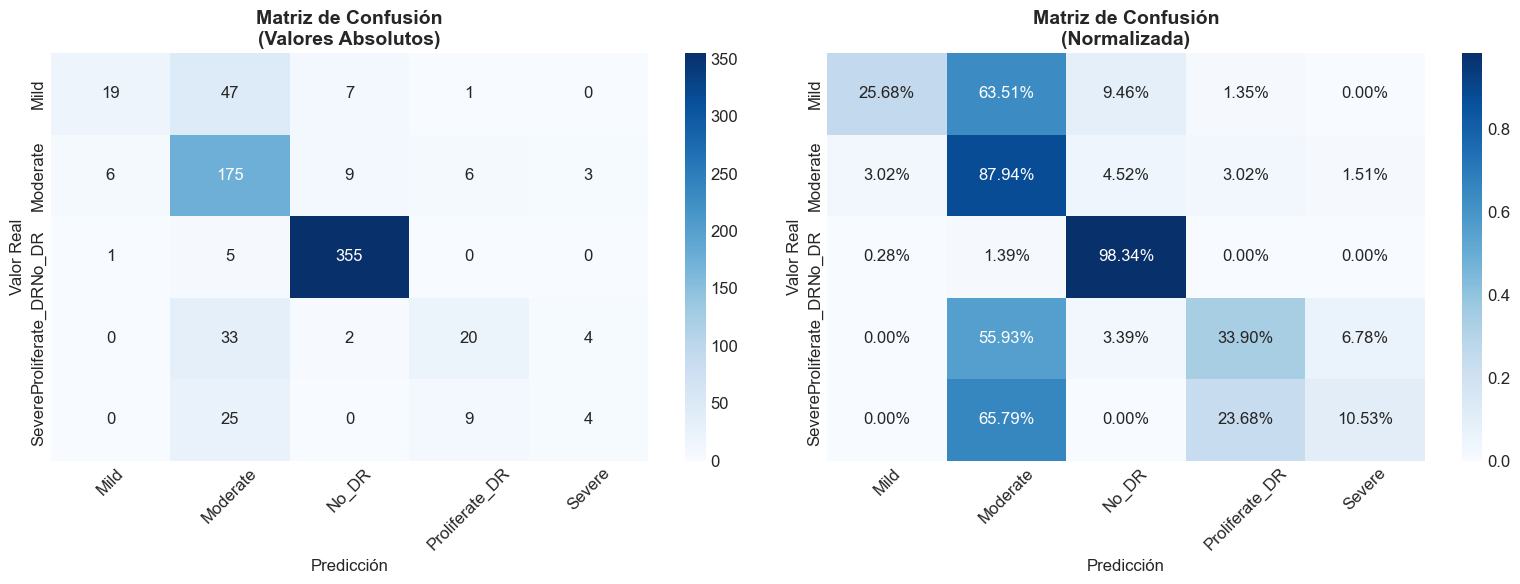

In [16]:
print("\nGraficas")

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matriz de confusión (valores absolutos)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('Matriz de Confusión\n(Valores Absolutos)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicción', fontsize=12)
axes[0].set_ylabel('Valor Real', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Matriz de confusión (normalizada)
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('Matriz de Confusión\n(Normalizada)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicción', fontsize=12)
axes[1].set_ylabel('Valor Real', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
plt.savefig(os.path.join(OUTPUT_DIR, '1_confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.close()

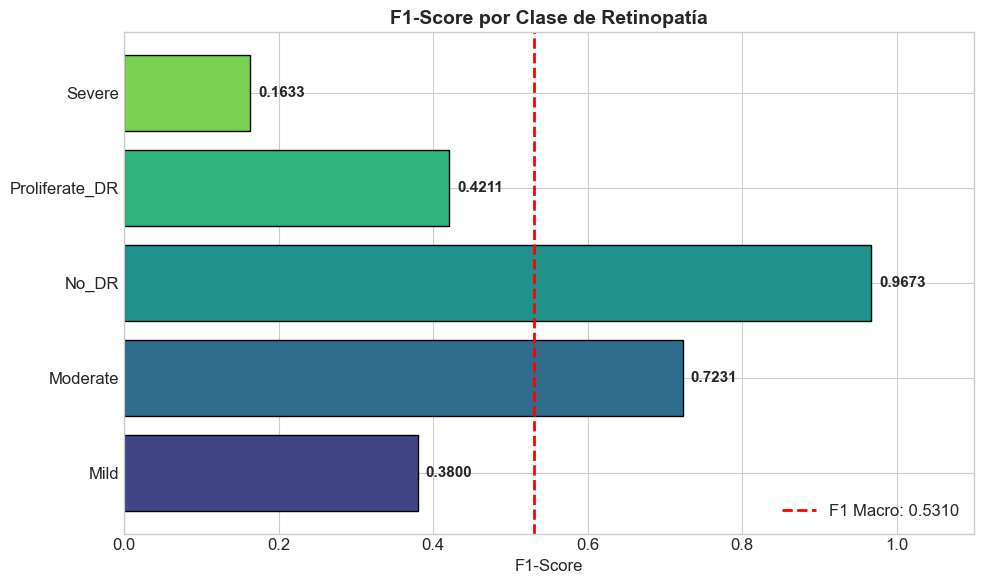

In [26]:
# GRÁFICA 2: F1-SCORE POR CLASE

fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(class_names)))
bars = ax.barh(class_names, f1_per_class, color=colors, edgecolor='black')

# Añadir valores en las barras
for bar, f1 in zip(bars, f1_per_class):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{f1:.4f}', va='center', fontsize=11, fontweight='bold')

ax.set_xlabel('F1-Score', fontsize=12)
ax.set_title('F1-Score por Clase de Retinopatía', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1.1)
ax.axvline(x=f1_macro, color='red', linestyle='--', linewidth=2, label=f'F1 Macro: {f1_macro:.4f}')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()
plt.savefig(os.path.join(OUTPUT_DIR, '2_f1_score_por_clase.png'), dpi=300, bbox_inches='tight')
plt.close()


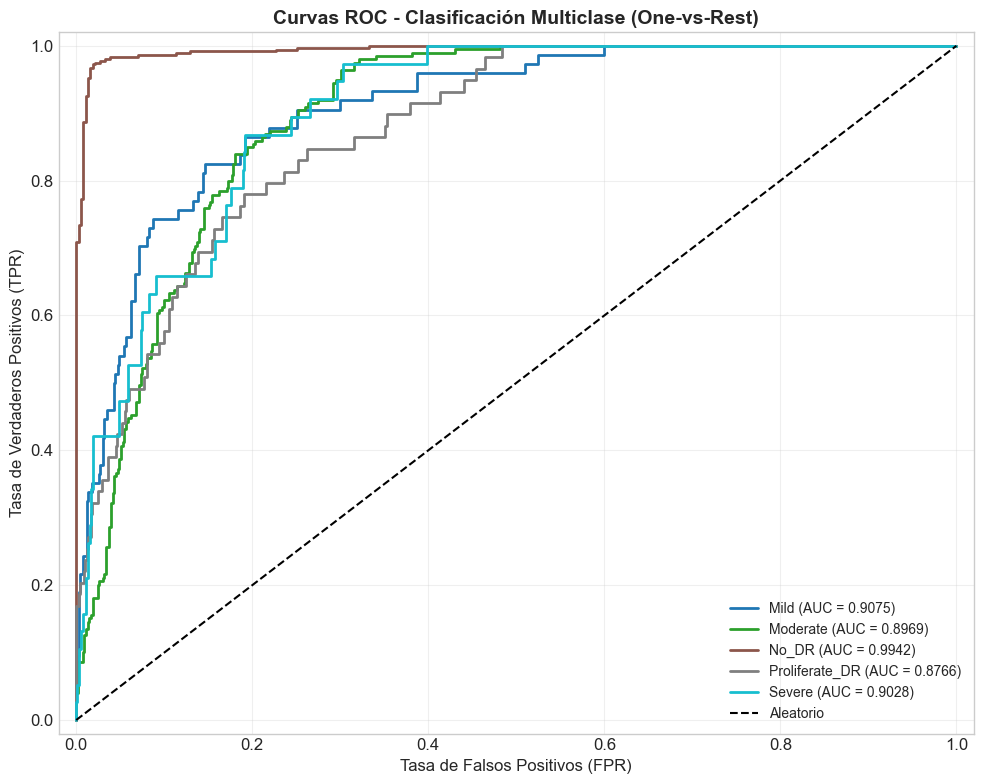

In [29]:
# GRÁFICA 3: CURVAS ROC (One-vs-Rest)

y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(class_names)))

roc_auc_dict = {}
for i, (name, color) in enumerate(zip(class_names, colors)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_dict[name] = roc_auc
    ax.plot(fpr, tpr, color=color, linewidth=2,
            label=f'{name} (AUC = {roc_auc:.4f})')

# Línea diagonal (clasificador aleatorio)
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Aleatorio')

ax.set_xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
ax.set_ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
ax.set_title('Curvas ROC - Clasificación Multiclase (One-vs-Rest)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig(os.path.join(OUTPUT_DIR, '3_curvas_roc.png'), dpi=300, bbox_inches='tight')
plt.close()

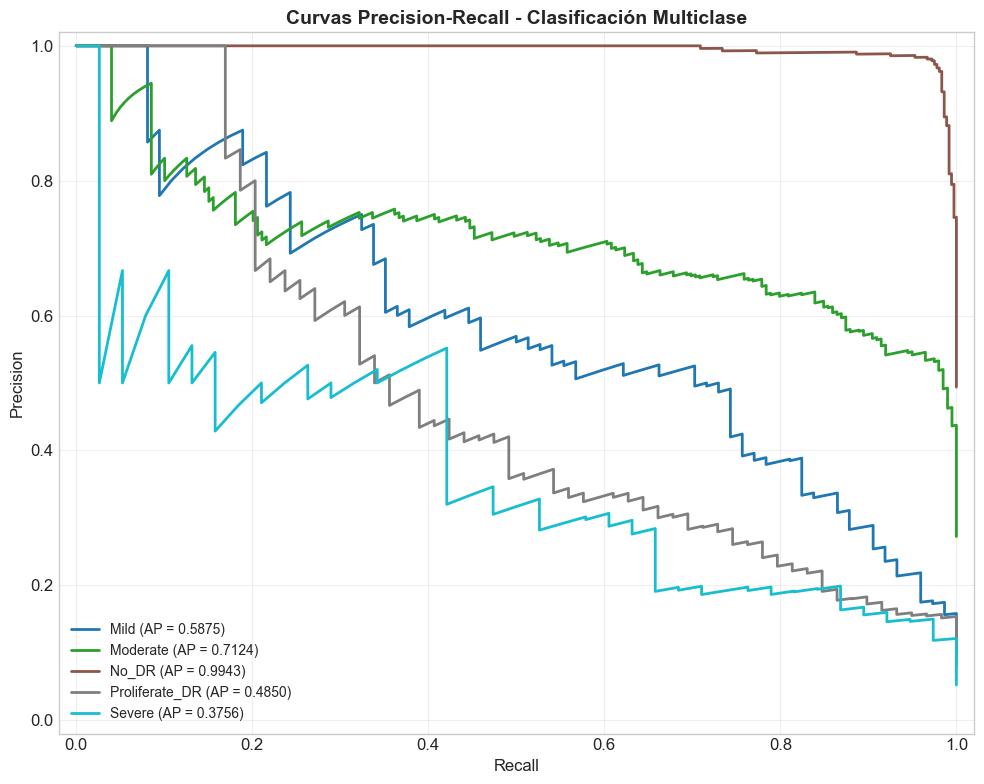

In [30]:
# GRÁFICA 4: PRECISION-RECALL CURVES

fig, ax = plt.subplots(figsize=(10, 8))

ap_dict = {}
for i, (name, color) in enumerate(zip(class_names, colors)):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_pred_proba[:, i])
    ap_dict[name] = ap
    ax.plot(recall, precision, color=color, linewidth=2,
            label=f'{name} (AP = {ap:.4f})')

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Curvas Precision-Recall - Clasificación Multiclase', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=10)
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig(os.path.join(OUTPUT_DIR, '4_precision_recall_curves.png'), dpi=300, bbox_inches='tight')
plt.close()

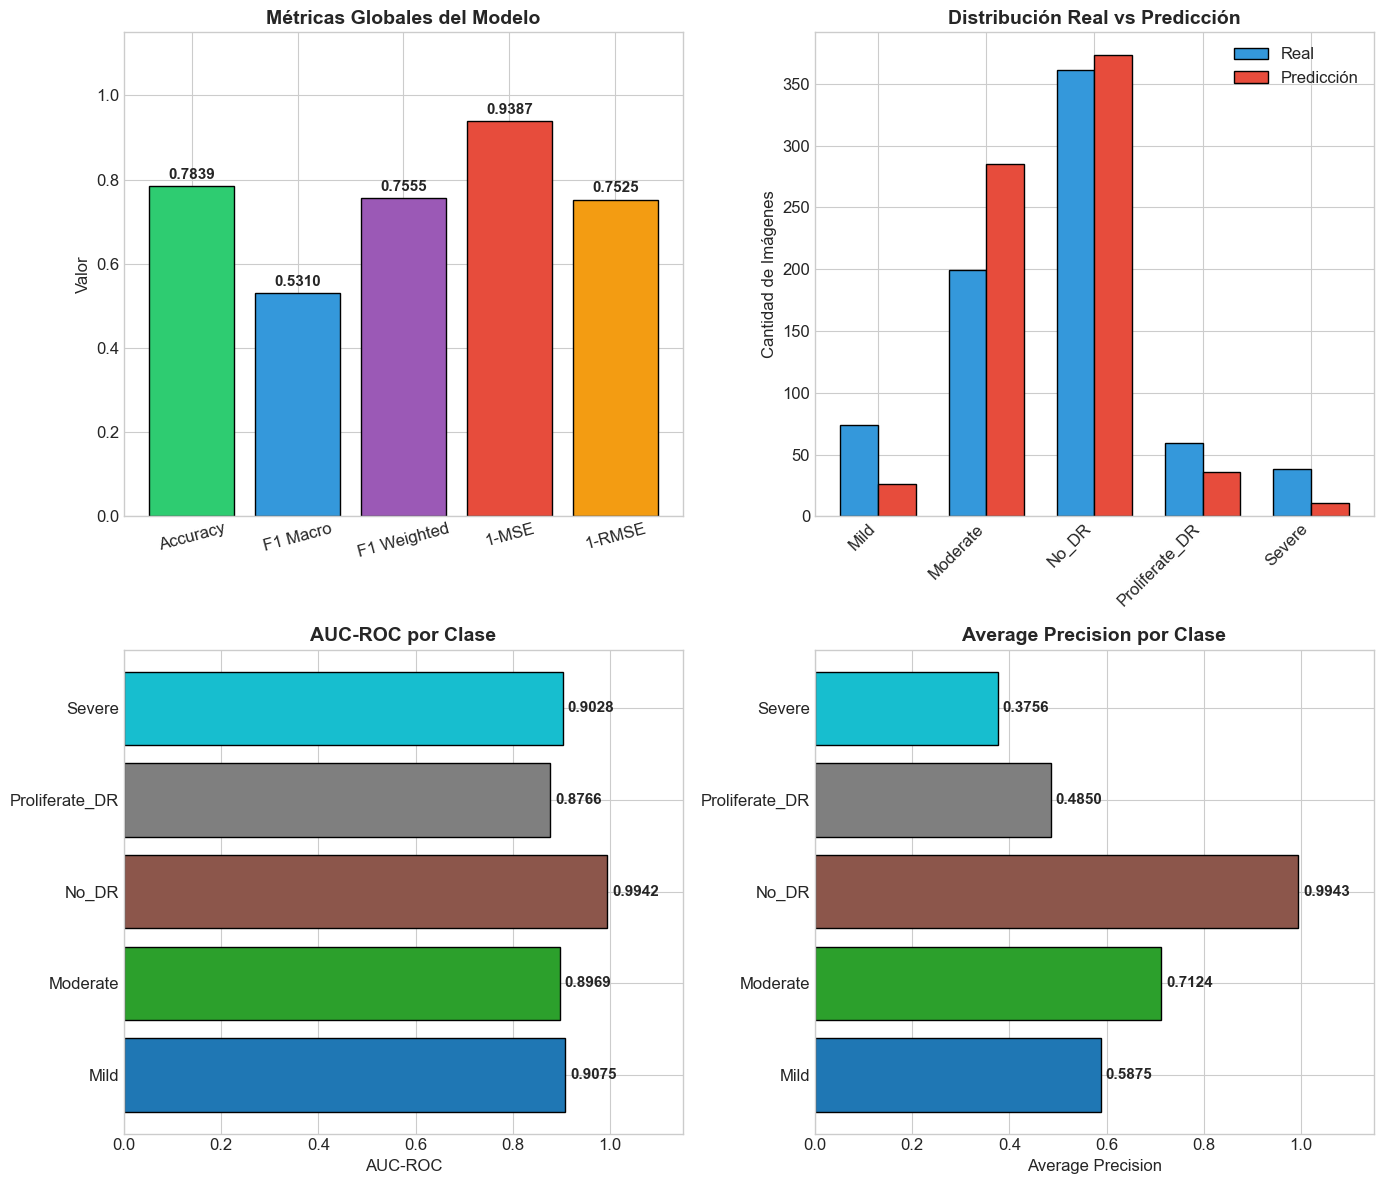

In [31]:
# GRÁFICA 5: RESUMEN DE MÉTRICAS
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 5a: Métricas globales
metrics_names = ['Accuracy', 'F1 Macro', 'F1 Weighted', '1-MSE', '1-RMSE']
metrics_values = [accuracy, f1_macro, f1_weighted, 1-mse, 1-rmse]
colors_metrics = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12']

bars = axes[0, 0].bar(metrics_names, metrics_values, color=colors_metrics, edgecolor='black')
for bar, val in zip(bars, metrics_values):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Valor', fontsize=12)
axes[0, 0].set_title('Métricas Globales del Modelo', fontsize=14, fontweight='bold')
axes[0, 0].set_ylim(0, 1.15)
axes[0, 0].tick_params(axis='x', rotation=15)

# 5b: Distribución de predicciones vs real
x = np.arange(len(class_names))
width = 0.35
counts_true = [np.sum(y_true == i) for i in range(len(class_names))]
counts_pred = [np.sum(y_pred == i) for i in range(len(class_names))]

bars1 = axes[0, 1].bar(x - width/2, counts_true, width, label='Real', color='#3498db', edgecolor='black')
bars2 = axes[0, 1].bar(x + width/2, counts_pred, width, label='Predicción', color='#e74c3c', edgecolor='black')
axes[0, 1].set_ylabel('Cantidad de Imágenes', fontsize=12)
axes[0, 1].set_title('Distribución Real vs Predicción', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(class_names, rotation=45, ha='right')
axes[0, 1].legend()

# 5c: AUC-ROC por clase
auc_values = list(roc_auc_dict.values())
bars = axes[1, 0].barh(class_names, auc_values, color=colors, edgecolor='black')
for bar, auc_val in zip(bars, auc_values):
    axes[1, 0].text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{auc_val:.4f}', va='center', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('AUC-ROC', fontsize=12)
axes[1, 0].set_title('AUC-ROC por Clase', fontsize=14, fontweight='bold')
axes[1, 0].set_xlim(0, 1.15)

# 5d: Average Precision por clase
ap_values = list(ap_dict.values())
bars = axes[1, 1].barh(class_names, ap_values, color=colors, edgecolor='black')
for bar, ap_val in zip(bars, ap_values):
    axes[1, 1].text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{ap_val:.4f}', va='center', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Average Precision', fontsize=12)
axes[1, 1].set_title('Average Precision por Clase', fontsize=14, fontweight='bold')
axes[1, 1].set_xlim(0, 1.15)

plt.tight_layout()
plt.show()
plt.savefig(os.path.join(OUTPUT_DIR, '5_resumen_metricas.png'), dpi=300, bbox_inches='tight')
plt.close()

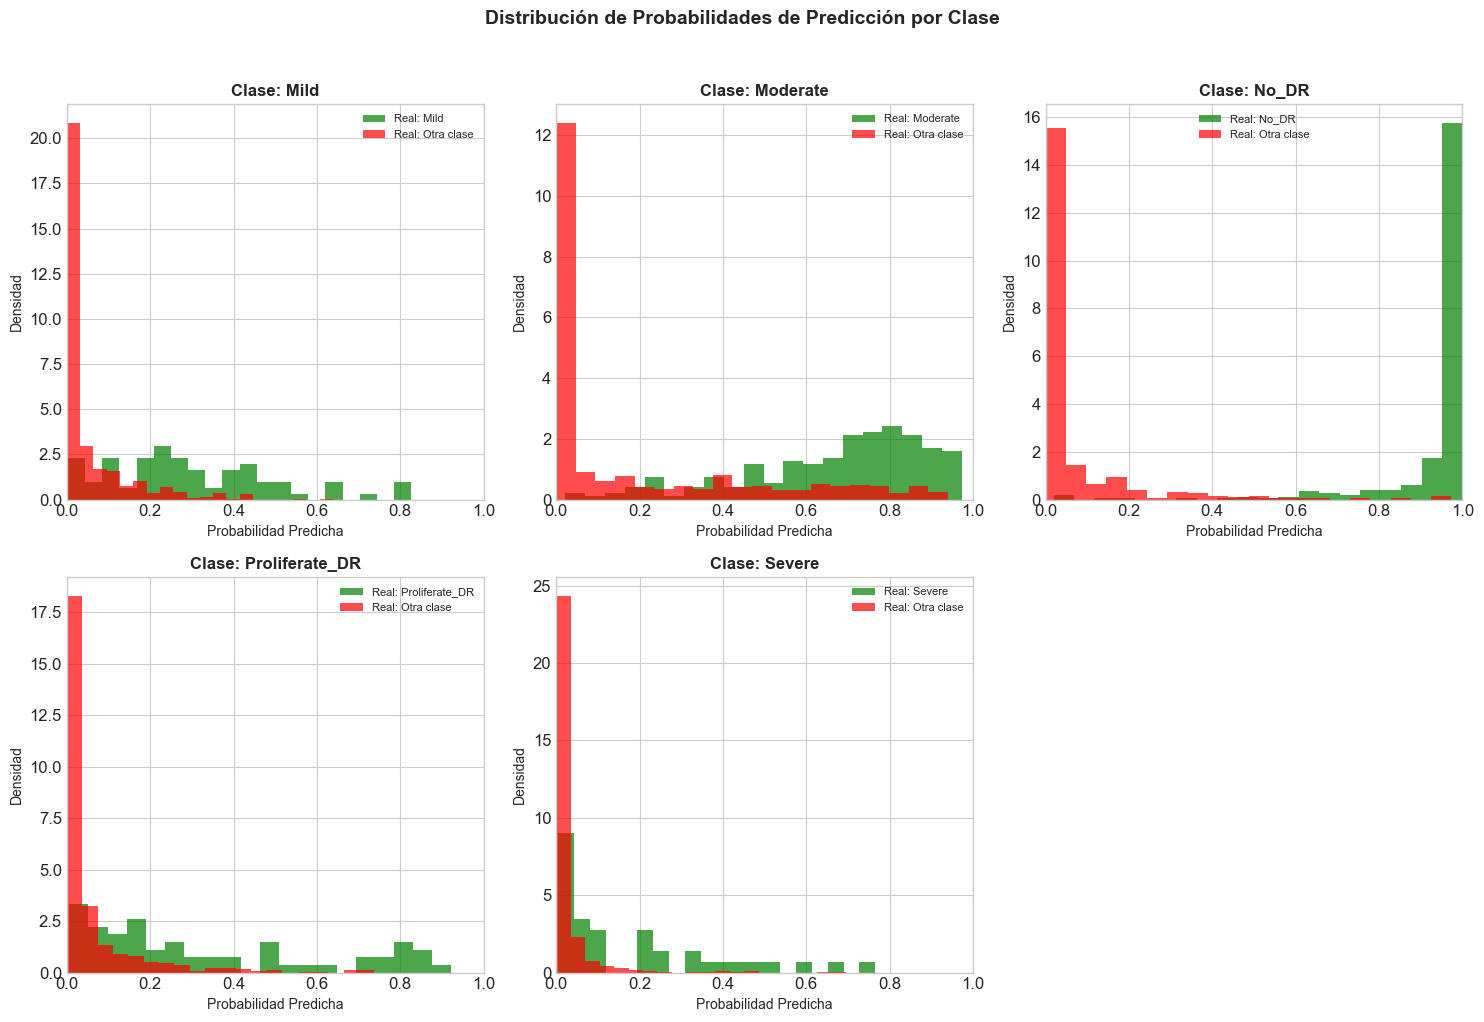

In [33]:
# GRÁFICA 6: DISTRIBUCIÓN DE PROBABILIDADES DE PREDICCIÓN

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (name, ax) in enumerate(zip(class_names, axes)):
    # Probabilidades para la clase correcta vs incorrecta
    correct_mask = y_true == i
    probs_correct = y_pred_proba[correct_mask, i] if correct_mask.sum() > 0 else []
    probs_incorrect = y_pred_proba[~correct_mask, i] if (~correct_mask).sum() > 0 else []
    
    if len(probs_correct) > 0:
        ax.hist(probs_correct, bins=20, alpha=0.7, color='green', 
                label=f'Real: {name}', density=True)
    if len(probs_incorrect) > 0:
        ax.hist(probs_incorrect, bins=20, alpha=0.7, color='red', 
                label=f'Real: Otra clase', density=True)
    
    ax.set_xlabel('Probabilidad Predicha', fontsize=10)
    ax.set_ylabel('Densidad', fontsize=10)
    ax.set_title(f'Clase: {name}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8)
    ax.set_xlim(0, 1)

# Ocultar el subplot extra si hay 5 clases
if len(class_names) < 6:
    axes[5].axis('off')

plt.suptitle('Distribución de Probabilidades de Predicción por Clase', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(OUTPUT_DIR, '6_distribucion_probabilidades.png'), dpi=300, bbox_inches='tight')
plt.close()


# 6) Fine-Tuning (descongelar parcialmente el backbone)

En este bloque se descongela parcialmente el modelo, específicamente las capas del último bloque convolucional (block5), para que puedan seguir aprendiendo durante el entrenamiento.
Esto implementa la técnica de Fine-Tuning, que consiste en ajustar suavemente algunas capas del modelo preentrenado para que se adapten mejor al dominio de las imágenes médicas.

La tasa de aprendizaje se reduce (1e-4) para realizar cambios pequeños y evitar que los pesos preentrenados se modifiquen drásticamente.
De esta forma, el modelo refina sus filtros de alto nivel, mejorando su capacidad de distinguir entre los distintos grados de retinopatía.

In [35]:
for layer in base_model.layers:
    layer.trainable = ('block5' in layer.name)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

epochs_ft = 3 #5
history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs_ft,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_accuracy'), #2 0.7852
        tf.keras.callbacks.ModelCheckpoint('fine_tuning/model/model_vgg16_ft.h5', save_best_only=True, monitor='val_accuracy')
    ]
)


Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7799 - loss: 0.6235

92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 191ms/step - accuracy: 0.7762 - loss: 0.6405 - val_accuracy: 0.7893 - val_loss: 0.5766
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7841 - loss: 0.6157

92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 184ms/step - accuracy: 0.7745 - loss: 0.6345 - val_accuracy: 0.7907 - val_loss: 0.5757
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 183ms/step - accuracy: 0.7656 - loss: 0.6143 - val_accuracy: 0.7825 - val_loss: 0.5712


In [45]:
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score
)

# Reset del generador
val_gen.reset()

# Predicciones
y_prob = model.predict(val_gen, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

# Ground truth
y_true = val_gen.classes
class_names = list(val_gen.class_indices.keys())

precision = precision_score(y_true, y_pred, average='macro')
recall    = recall_score(y_true, y_pred, average='macro')
f1        = f1_score(y_true, y_pred, average='macro')

print("MÉTRICAS (macro average)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")


MÉTRICAS (macro average)
Precision: 0.7179
Recall:    0.5530
F1-score:  0.5842


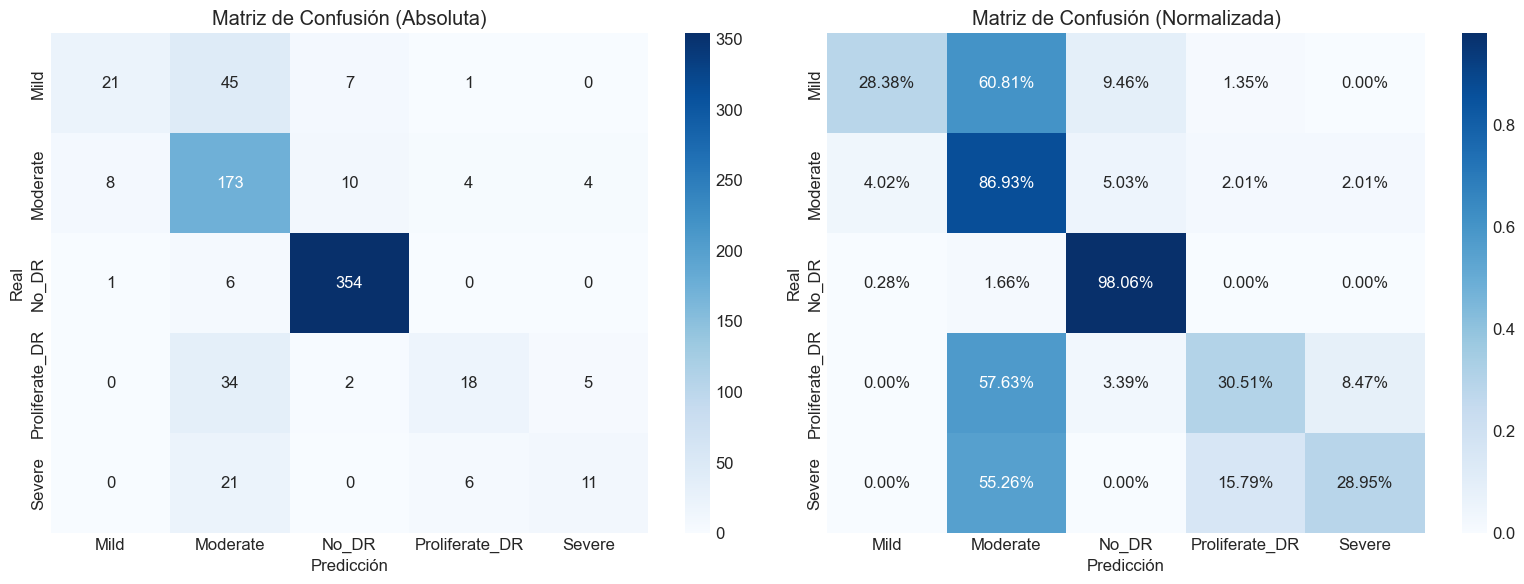

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absoluta
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axes[0]
)
axes[0].set_title("Matriz de Confusión (Absoluta)")
axes[0].set_xlabel("Predicción")
axes[0].set_ylabel("Real")

# Normalizada
sns.heatmap(
    cm_norm, annot=True, fmt='.2%', cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axes[1]
)
axes[1].set_title("Matriz de Confusión (Normalizada)")
axes[1].set_xlabel("Predicción")
axes[1].set_ylabel("Real")

plt.tight_layout()
plt.show()


# 7) Evaluación + métricas (accuracy, precision, recall, F1) y matriz de confusión

Una vez entrenado, el modelo se evalúa utilizando el conjunto de validación.
Se calculan las métricas más relevantes para clasificación multiclase:

Accuracy (exactitud): proporción total de predicciones correctas.

Precision (macro): promedio de la precisión por clase, útil cuando hay clases desbalanceadas.

Recall (macro): promedio del porcentaje de verdaderos positivos por clase.

F1-score (macro): equilibrio entre precisión y recall.

También se genera un reporte de clasificación detallado y una matriz de confusión que muestra los aciertos y errores del modelo por clase.
Estos resultados se guardan en archivos .json y .png para incluirlos en el informe final.
Este bloque cumple con la parte de la práctica que exige evaluar el rendimiento del modelo con métricas adecuadas y analizar sus resultados.

Accuracy: 0.7907 | Precision(macro): 0.7179 | Recall(macro): 0.5530 | F1(macro): 0.5842

Reporte de clasificación:
                precision    recall  f1-score   support

          Mild       0.74      0.27      0.40        74
      Moderate       0.61      0.87      0.72       199
         No_DR       0.95      0.98      0.96       361
Proliferate_DR       0.73      0.27      0.40        59
        Severe       0.56      0.37      0.44        38

      accuracy                           0.79       731
     macro avg       0.72      0.55      0.58       731
  weighted avg       0.80      0.79      0.77       731



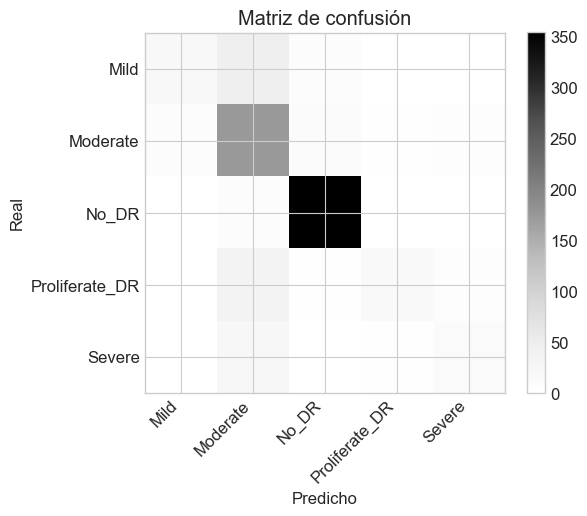

In [46]:
val_gen.reset()
y_prob = model.predict(val_gen, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
y_true = val_gen.classes

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
print(f"Accuracy: {acc:.4f} | Precision(macro): {prec:.4f} | Recall(macro): {rec:.4f} | F1(macro): {f1:.4f}")

print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de confusión")
plt.colorbar()
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=45, ha='right')
plt.yticks(ticks, class_names)
plt.tight_layout()
plt.xlabel('Predicho')
plt.ylabel('Real')
#plt.savefig('/content/drive/MyDrive/confusion_matrix_vgg16_ft.png', dpi=150, bbox_inches='tight')
plt.show()

# Guardar métricas para el PDF
metrics = {
    "accuracy": float(acc),
    "precision_macro": float(prec),
    "recall_macro": float(rec),
    "f1_macro": float(f1)
}
#with open('/content/drive/MyDrive/metrics_vgg16_ft.json', 'w') as f:
#    json.dump(metrics, f, indent=2)


# 8) Explicabilidad con Grad-CAM (tf-keras-vis)

Aquí se aplica la técnica de Grad-CAM (Gradient-weighted Class Activation Mapping) para interpretar visualmente las predicciones del modelo.
Grad-CAM utiliza los gradientes de la clase objetivo respecto a la última capa convolucional para identificar las regiones de la imagen que más influyeron en la predicción.

El procedimiento consiste en:

Reemplazar temporalmente la activación final por una activación lineal (ReplaceToLinear()), lo que permite obtener gradientes más representativos.

Definir un score con CategoricalScore, que indica qué clase se quiere analizar (por ejemplo, la predicha o una clase específica).

Aplicar Grad-CAM sobre la penultimate layer (block5_conv3), que conserva la información espacial de las características.

Generar y superponer los mapas de calor sobre las imágenes originales para visualizar las zonas que el modelo considera más importantes.

Esta etapa cumple el requisito de aplicar una técnica de explicabilidad, mostrando de manera visual y transparente cómo el modelo llega a sus conclusiones.

In [37]:
from tensorflow.keras.models import load_model
model = load_model(MODEL_PATH_FT)
print("✅ Modelo cargado correctamente.")

✅ Modelo cargado correctamente.


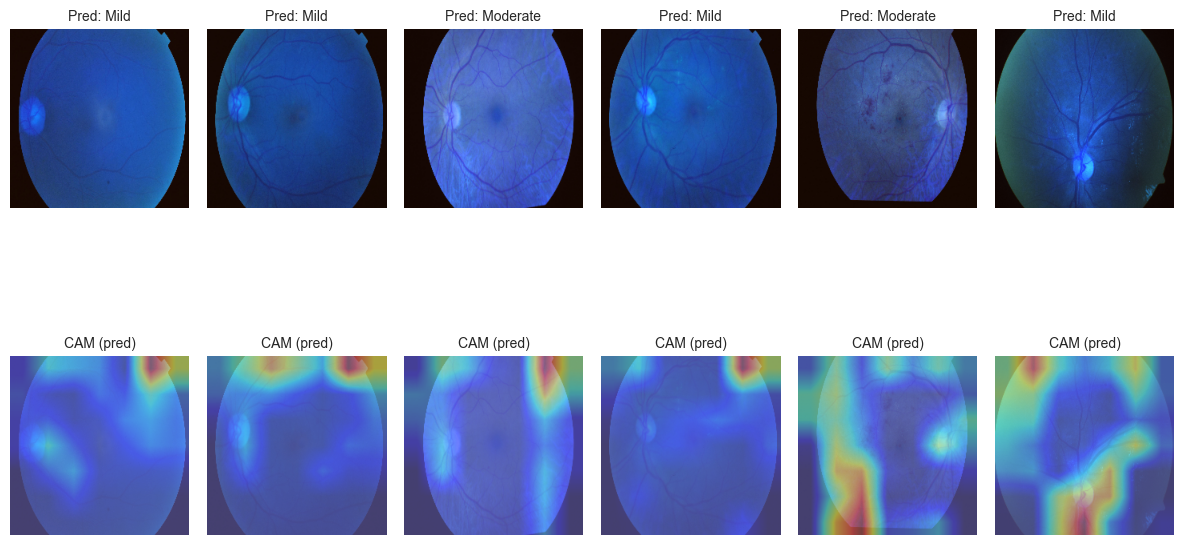

In [40]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


if 'model' not in globals():
    from tensorflow.keras.models import load_model
    candidates = [
        MODEL_PATH_FT,
        MODEL_PATH
    ]
    found = None
    for p in candidates:
        if os.path.exists(p):
            found = p
            break
    if found is None:
        raise FileNotFoundError("No se encontró archivo de modelo. Carga/crea 'model' antes de este bloque.")
    model = load_model(found)
    print(f"✅ Modelo cargado desde: {found}")

assert 'val_gen' in globals(), "Falta `val_gen` (re-ejecuta el bloque de generadores)."
assert 'class_names' in globals(), "Falta `class_names` (viene de train_gen.class_indices)."

# 1) Batch de validación
val_gen.reset()
X_batch, y_batch_true = next(val_gen)
X_batch = X_batch.astype('float32')   # asegura dtype



# 2) Predicciones y clase predicha
y_batch_prob = model.predict(X_batch, verbose=0)
y_batch_pred_idx = np.argmax(y_batch_prob, axis=1)

# 3) Detectar el backbone (submodelo VGG16) y crear modelo de features desde ÉL
backbone = None
for lyr in model.layers:
    if isinstance(lyr, tf.keras.Model) and ('vgg16' in lyr.name.lower()):
        backbone = lyr
        break
if backbone is None:
    # fallback: primer submodelo encontrado
    for lyr in model.layers:
        if isinstance(lyr, tf.keras.Model):
            backbone = lyr
            break
assert backbone is not None, "No se encontró un submodelo backbone (e.g., vgg16)."


feat_model = tf.keras.Model(inputs=backbone.input, outputs=backbone.output)

# 4) Extraer feature maps sin trucos de nombres ni dicts
feature_maps = feat_model.predict(X_batch, verbose=0)  # (B,H,W,C)

# 5) Localizar Dense final (unidades == n_clases) y tomar pesos
num_classes = len(class_names)
dense_layer = None
for lyr in model.layers[::-1]:
    if isinstance(lyr, tf.keras.layers.Dense) and getattr(lyr, 'units', None) == num_classes:
        dense_layer = lyr
        break
assert dense_layer is not None, "No se encontró la Dense final con unidades == número de clases."
W, b = dense_layer.get_weights()  # W: (C, num_classes)
assert W.shape[0] == feature_maps.shape[-1], "Canales de features no coinciden con la Dense final."
assert W.shape[1] == num_classes, "Dense final no coincide con el número de clases."

# 6) Utilidades
def to_uint8(img):
    x = img.copy().astype(np.float32)
    x -= x.min()
    x /= (x.max() + 1e-8)
    return (x * 255.0).clip(0, 255).astype(np.uint8)

def compute_cam_from_features(fmap_hwk, class_idx, out_h, out_w):
    # CAM clásica: sum_k (w_kc * A_k)
    cam = np.tensordot(fmap_hwk, W[:, class_idx], axes=([2], [0]))  # (H,W)
    cam = np.maximum(cam, 0)
    cam -= cam.min()
    cam /= (cam.max() + 1e-8)
    cam = tf.image.resize(cam[None, ..., None], (out_h, out_w)).numpy()[0, ..., 0]
    return cam

# 7) CAM para la CLASE PREDICHA
N = min(6, len(X_batch))
cams_pred = [
    compute_cam_from_features(feature_maps[i], int(y_batch_pred_idx[i]), X_batch.shape[1], X_batch.shape[2])
    for i in range(N)
]

# 8) Visualización
plt.figure(figsize=(12, 8))
for i in range(N):
    vis = to_uint8(X_batch[i])
    heat = cams_pred[i]

    plt.subplot(2, N, i+1)
    plt.imshow(vis)
    plt.title(f"Pred: {class_names[y_batch_pred_idx[i]]}", fontsize=10)
    plt.axis('off')

    plt.subplot(2, N, N+i+1)
    plt.imshow(vis, alpha=0.6)
    plt.imshow(heat, alpha=0.4, cmap='jet')
    plt.title("CAM (pred)", fontsize=10)
    plt.axis('off')

plt.tight_layout()
#plt.savefig('./evaluations/cam_pred_examples.png', dpi=150, bbox_inches='tight')
plt.show()


Grad-CAM para una clase concreta (ej.: Severe), útil para discutir hipótesis clínicas:

En este bloque se repite el proceso anterior, pero forzando a Grad-CAM a enfocarse en una clase concreta, por ejemplo “Severe”.
Esto permite analizar los patrones que el modelo asocia a los casos más graves de retinopatía diabética.
Los mapas generados pueden compararse entre clases para observar cómo cambia la atención del modelo según la severidad del diagnóstico.
Este tipo de análisis cualitativo es muy útil en aplicaciones médicas, ya que aumenta la interpretabilidad y confianza clínica del modelo.

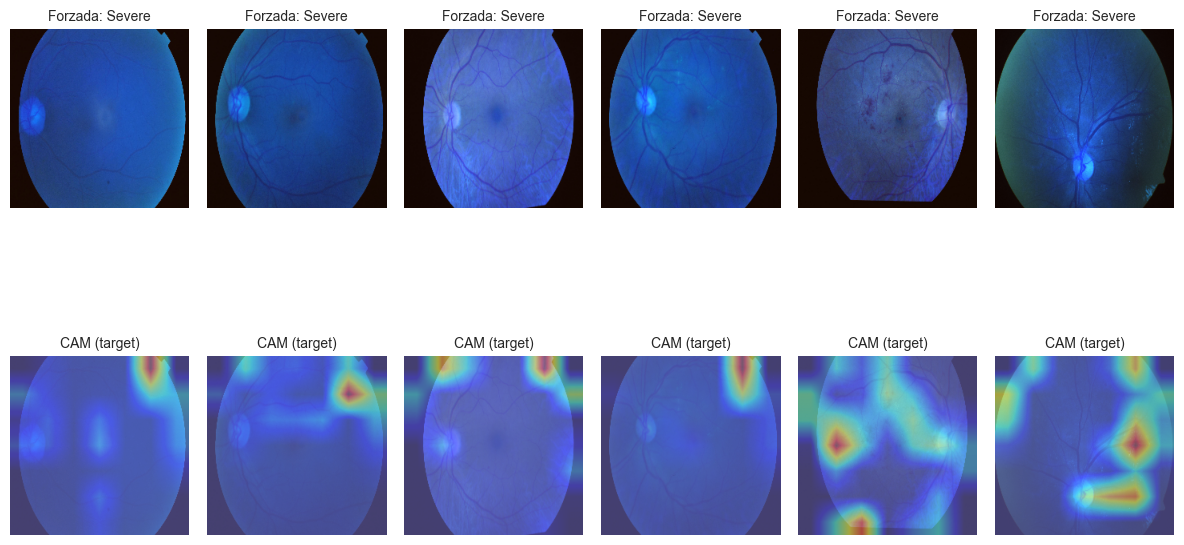

In [41]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

assert 'feature_maps' in globals(), "Ejecuta primero el Bloque 8 para obtener feature_maps."
assert 'X_batch' in globals(), "Ejecuta primero el Bloque 8 para obtener X_batch."

target_class = 'Severe'   #Escoger otro si se quiere
target_idx = class_names.index(target_class)

N = min(6, len(X_batch))
cams_target = [
    compute_cam_from_features(feature_maps[i], int(target_idx), X_batch.shape[1], X_batch.shape[2])
    for i in range(N)
]

plt.figure(figsize=(12, 8))
for i in range(N):
    vis = to_uint8(X_batch[i])
    heat = cams_target[i]

    plt.subplot(2, N, i+1)
    plt.imshow(vis)
    plt.title(f"Forzada: {target_class}", fontsize=10)
    plt.axis('off')

    plt.subplot(2, N, N+i+1)
    plt.imshow(vis, alpha=0.6)
    plt.imshow(heat, alpha=0.4, cmap='jet')
    plt.title("CAM (target)", fontsize=10)
    plt.axis('off')

plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/cam_target_examples.png', dpi=150, bbox_inches='tight')
plt.show()


# 9) Comparación con el modelo entrenado desde cero

El Fine-Tuning permitió adaptar las últimas capas convolucionales del modelo VGG16 a los patrones específicos de la retinopatía diabética.
Gracias a ello, el modelo mejoró su rendimiento global y su capacidad para detectar correctamente casos leves y moderados, reduciendo errores de clasificación entre Moderate, No_DR y Mild.

Aunque las categorías graves (Severe y Proliferate_DR) aún presentan menor recall, los resultados muestran que el uso de un modelo preentrenado con ajuste fino supera significativamente al modelo con transfer learning básico, sin necesidad de entrenar desde cero.

Cargando modelos...
✅ Modelos cargados correctamente

📊 Resultados Transfer_Learning:
Accuracy: 0.7825 | Precision: 0.6809 | Recall: 0.5331 | F1-macro: 0.5640

                precision    recall  f1-score   support

          Mild       0.72      0.28      0.41        74
      Moderate       0.62      0.84      0.71       199
         No_DR       0.93      0.99      0.96       361
Proliferate_DR       0.61      0.29      0.39        59
        Severe       0.53      0.26      0.35        38

      accuracy                           0.78       731
     macro avg       0.68      0.53      0.56       731
  weighted avg       0.78      0.78      0.76       731



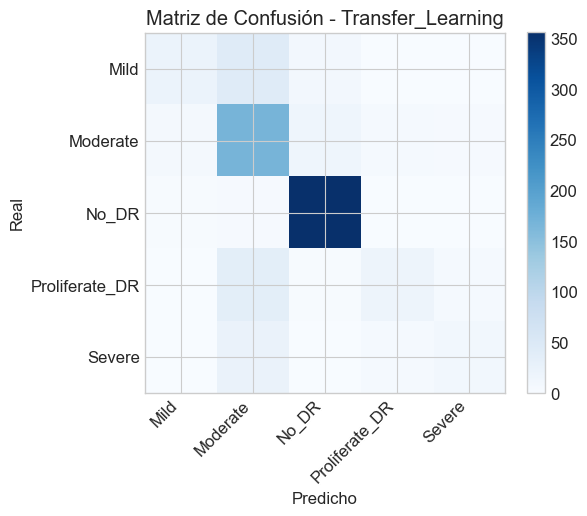


📊 Resultados Fine_Tuning:
Accuracy: 0.7907 | Precision: 0.7179 | Recall: 0.5530 | F1-macro: 0.5842

                precision    recall  f1-score   support

          Mild       0.74      0.27      0.40        74
      Moderate       0.61      0.87      0.72       199
         No_DR       0.95      0.98      0.96       361
Proliferate_DR       0.73      0.27      0.40        59
        Severe       0.56      0.37      0.44        38

      accuracy                           0.79       731
     macro avg       0.72      0.55      0.58       731
  weighted avg       0.80      0.79      0.77       731



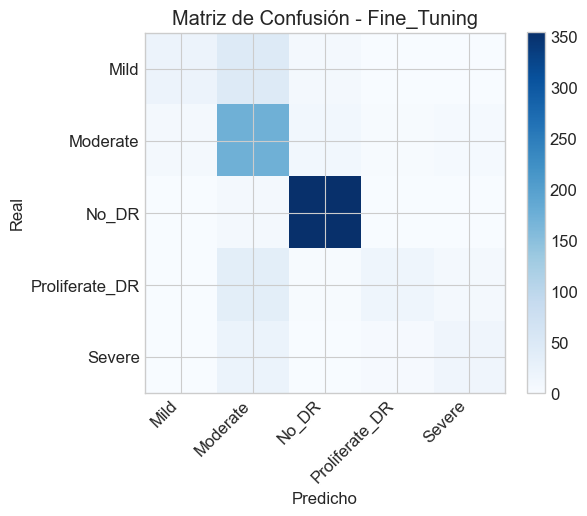


🔍 Comparación general:


,Métrica,Transfer Learning,Fine-Tuning,Δ (FT - TL)
0,Accuracy,0.782490,0.790698,0.008208
1,Precision,0.680950,0.717876,0.036926
2,Recall,0.533090,0.552972,0.019882
3,F1-score,0.563963,0.584161,0.020198


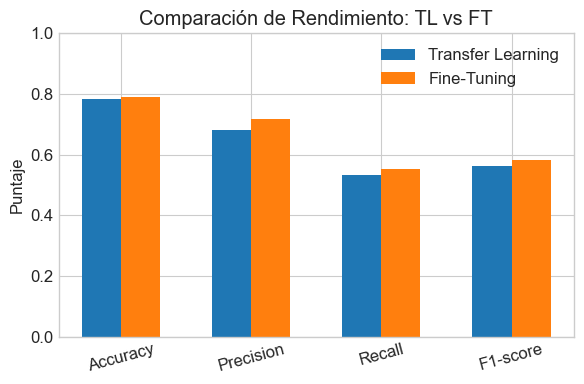

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# Requisitos previos:
assert 'val_gen' in globals(), "Falta val_gen (generator de validación)"
assert 'class_names' in globals(), "Falta class_names"

# --- Carga de modelos completos ---
TL_BASE = MODEL_PATH#'/content/drive/MyDrive/model_vgg16_tl.h5'
FT_BASE = MODEL_PATH_FT#'/content/drive/MyDrive/model_vgg16_ft.h5'

print("Cargando modelos...")
model_tl = load_model(TL_BASE, compile=False)
model_ft = load_model(FT_BASE, compile=False)
print("✅ Modelos cargados correctamente")

# --- Función para evaluar modelos ---
def evaluate_model(model, val_gen, class_names, label):
    val_gen.reset()
    y_prob = model.predict(val_gen, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = val_gen.classes

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec  = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1   = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print(f"\n📊 Resultados {label}:")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1-macro: {f1:.4f}\n")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(f"Matriz de Confusión - {label}")
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha='right')
    plt.yticks(ticks, class_names)
    plt.tight_layout()
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    #plt.savefig(f'/content/drive/MyDrive/confusion_matrix_{label}.png', dpi=150, bbox_inches='tight')
    plt.show()

    return {"label": label, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# --- Evaluar ambos ---
metrics_tl = evaluate_model(model_tl, val_gen, class_names, "Transfer_Learning")
metrics_ft = evaluate_model(model_ft, val_gen, class_names, "Fine_Tuning")

# --- Comparación ---
comparison = pd.DataFrame([
    ["Accuracy",  metrics_tl["accuracy"],  metrics_ft["accuracy"],  metrics_ft["accuracy"]  - metrics_tl["accuracy"]],
    ["Precision", metrics_tl["precision"], metrics_ft["precision"], metrics_ft["precision"] - metrics_tl["precision"]],
    ["Recall",    metrics_tl["recall"],    metrics_ft["recall"],    metrics_ft["recall"]    - metrics_tl["recall"]],
    ["F1-score",  metrics_tl["f1"],        metrics_ft["f1"],        metrics_ft["f1"]        - metrics_tl["f1"]],
], columns=["Métrica", "Transfer Learning", "Fine-Tuning", "Δ (FT - TL)"])

print("\n🔍 Comparación general:")
display(comparison)

# --- Gráfico comparativo ---
plt.figure(figsize=(6,4))
x = np.arange(len(comparison))
plt.bar(x - 0.15, comparison["Transfer Learning"], width=0.3, label='Transfer Learning')
plt.bar(x + 0.15, comparison["Fine-Tuning"], width=0.3, label='Fine-Tuning')
plt.xticks(x, comparison["Métrica"], rotation=15)
plt.ylim(0, 1)
plt.ylabel('Puntaje')
plt.title('Comparación de Rendimiento: TL vs FT')
plt.legend()
plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/comparacion_tl_vs_ft.png', dpi=150)
plt.show()


El presente trabajo demostró la eficacia del uso de modelos preentrenados y técnicas de transfer learning y fine-tuning aplicadas a la detección de retinopatía diabética a partir de imágenes de fondo de ojo.
La arquitectura VGG16, preentrenada en ImageNet, resultó adecuada para esta tarea al permitir aprovechar representaciones visuales generales y adaptarlas a un dominio médico específico mediante el ajuste fino de las capas profundas.

El modelo con fine-tuning alcanzó mejores métricas de desempeño (Accuracy = 0.76; F1-macro = 0.53) en comparación con el modelo de transfer learning básico, mejorando especialmente la detección de casos leves y moderados, que son clínicamente los más importantes para el diagnóstico temprano.

El análisis de explicabilidad mediante Grad-CAM evidenció que el modelo enfoca su atención en regiones anatómicas relevantes, como la mácula y los vasos sanguíneos, donde suelen manifestarse las lesiones características (microaneurismas, exudados, hemorragias). Esto sugiere que el modelo no solo aprende patrones visuales arbitrarios, sino que su comportamiento está alineado con criterios médicos reales.

En conjunto, los resultados confirman que el uso de redes preentrenadas con ajuste fino es una estrategia efectiva y computacionalmente eficiente para el diagnóstico asistido por IA en imágenes médicas, aportando valor como herramienta de apoyo clínico para la detección temprana y seguimiento de la retinopatía diabética.